# Logistic Regression with Mini-Batch Gradient Descent
<h2>Objective</h2>

<ul>
    <li>Represent your data as a Dataset object</li>
    <li>Create a Logistic Regression Model using PyTorch</li>
    <li>Set a Criterion to calculate Loss</li>
    <li>Create a Data Loader and set the Batch Size</li>
    <li>Create an Optimizer to update Model Parameters and set Learning Rate</li>
    <li>Train a Model</li>
</ul> 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

## visualize the data space and the parameter space during training

In [48]:
class plot_error_surfaces(object):
    #Constructor
    def __init__(self,wrange,brange,X,Y,nsamples=30,go=True):
        W=np.linspace(-wrange,wrange,nsamples)
        B=np.linspace(-brange,brange,nsamples)
        w,b = np.meshgrid(W,B)
        Z=np.zeros((30,30))
        count1=0
        self.x=X.numpy()
        self.y=Y.numpy()
        for w1, b1 in zip(w,b):
            count2=0
            for w2, b2 in zip(w1,b1):
                yhat=1/(1+np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16)+(1-self.y)*np.log(1-yhat+1e-16))
                count2+=1
            count1+=1
        self.Z=Z
        self.w=w
        self.b=b
        self.W=[]
        self.B=[]
        self.LOSS=[]
        self.n=0
        if go==True:
            plt.figure()
            plt.figure(figsize=(7.5,5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis',edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surfafce Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w,self.b, self.Z)
            plt.show()

        # Setter 
    def set_para_loss(self, model, loss):
        self.n=self.n+1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)

        #plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x[self.y==0],self.y[self.y==0],'ro', label='training points')
        plt.plot(self.x[self.y==1],self.y[self.y==1],'o', label='training points')
        plt.plot(self.x,self.W[-1]*self.x +self.B[-1], label='estimated line')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1,2))
        plt.title('Data Space Iteration: '+str(self.n))
        plt.show()
        plt.ssubplot(122)
        plt.title('Loss Surface Contour Iteration'+str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')

    def PlotStuff(X,Y, model, epoch, leg=True):
        plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch'+str(epoch)))
        plt.plot(X.numpy(), Y.numpy(), 'r')
        if leg==True:
            plt.legend()
        else:
            pass
        
    
    
            

## Set random seed: setting the seed will allow is to control randomness and give us reproducibility 

In [5]:
torch.manual_seed(0)

# load Data

In [6]:
class Data(Dataset):

    def __init__(self):
        # create x values from -1 to 1 with steps .1
        self.x=torch.arange(-1,1,0.1).view(-1,1)
        # create y values all set to 0
        self.y=torch.zeros(self.x.shape[0],1)
        # set x values above 0.2 to 1
        self.y[self.x[:,0]>0.2]=1
        # set the .len attribute because we need to overrided the __len__ method 
        self.len=self.x.shape[0]

    # getter that returns the data at a given index
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    # get length of the dataset
    def __len__(self):
        return self.len


## make data object

In [7]:
data_set=Data()

In [8]:
data_set.x

tensor([[-1.0000e+00],
        [-9.0000e-01],
        [-8.0000e-01],
        [-7.0000e-01],
        [-6.0000e-01],
        [-5.0000e-01],
        [-4.0000e-01],
        [-3.0000e-01],
        [-2.0000e-01],
        [-1.0000e-01],
        [-2.9802e-09],
        [ 1.0000e-01],
        [ 2.0000e-01],
        [ 3.0000e-01],
        [ 4.0000e-01],
        [ 5.0000e-01],
        [ 6.0000e-01],
        [ 7.0000e-01],
        [ 8.0000e-01],
        [ 9.0000e-01]])

In [9]:
data_set.y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [10]:
len(data_set)

20

In [11]:
x,y=data_set[0]

In [12]:
x,y

(tensor([-1.]), tensor([0.]))

## we can seperate the one-dimensional dataset into 2 classes

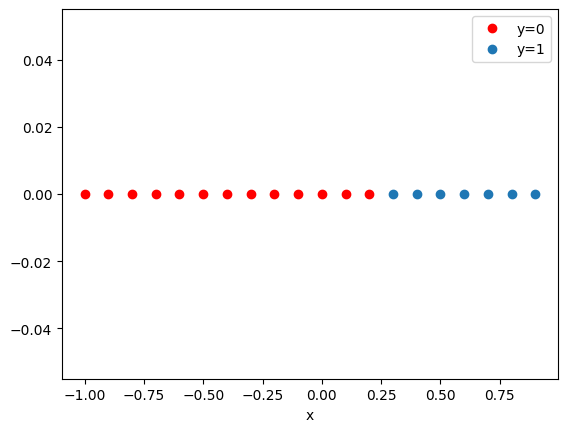

In [13]:
plt.plot(data_set.x[data_set.y==0],data_set.y[data_set.y==0],'ro',label='y=0')
plt.plot(data_set.x[data_set.y==1],data_set.y[data_set.y==1]-1,'o',label='y=1')
plt.xlabel('x')
plt.legend()

# create the model and total loss function (cost)

for logistic regression we generally use scikit-learn
pytorch is generally used for deep learning 

create custom class that defines the architecture of Logistic regression using pytorch
single layer - input is the number features an X value of the dataset has (dimension of X) and there is a single output.

output layer is put into sigmoid function 0 and 1
sigmoid function - classification problem

In [37]:
# Create logistic regression class that inherits nn,Module
class logistic_regression(nn.Module):
    def __init__(self, n_inputs):
        super(logistic_regression,self).__init__()
        self.linear=nn.Linear(n_inputs,1)

    def forward(self,x):
        yhat=torch.sigmoid(self.linear(x))
        return yhat

In [43]:
x,y = data_set[0]
len(x)

1

In [44]:
model=logistic_regression(1)

In [45]:
x=torch.tensor([-1.0])
sigma=model(x)
sigma

tensor([0.5264], grad_fn=<SigmoidBackward0>)

In [46]:
x,y,=data_set[2]
sigma=model(x)
sigma

tensor([0.5113], grad_fn=<SigmoidBackward0>)

<Figure size 640x480 with 0 Axes>

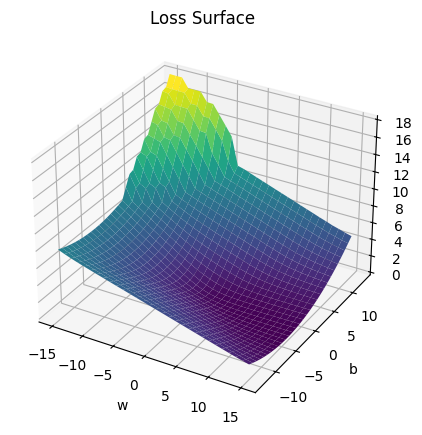

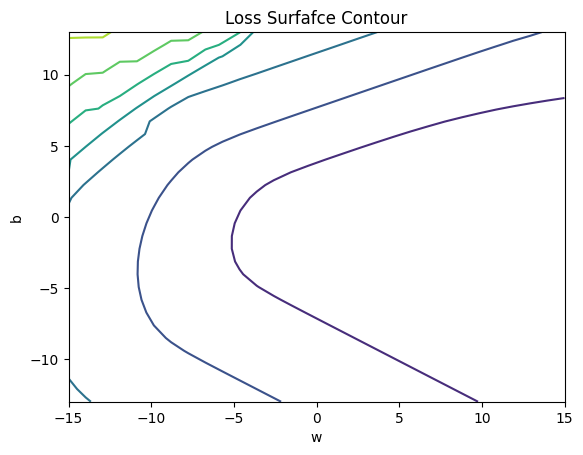

In [49]:
get_surface=plot_error_surfaces(15,13,data_set[:][0], data_set[:][1])